In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import PIL
from PIL import ImageFile, Image

ImageFile.LOAD_TRUNCATED_IMAGES = True
import pathlib
from tqdm import tqdm

from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
import warnings
warnings.filterwarnings("ignore")
from itertools import chain

## General Idea:
* New model needs to accept one date and norcal or socal.
* XGBoost predicts risk of fire on dates.
* Xception identifies amount of smoke in satellite image.
* New model averages out (weighted?) smoke/fire risk.
* Displays how likely fire was on that day.

## LSTM Motivation:
* Calculate the following for current day.
* XGBoost risk of fire given past x days.
* Xception risk of fire given past x days of images.
* ...more research needed

In [16]:
norcal_df = pd.read_csv('../../data/norcal.csv')
socal_df = pd.read_csv('../../data/socal.csv')

In [11]:
# Using just norcal dataframe
norcal_df.columns
drop = ['Max Air Temp (F)', 'Min Air Temp (F)', 'Max Rel Hum (%)', 'Min Rel Hum (%)']

In [12]:
norcal_df_2 = norcal_df.drop(drop, axis=1)

In [15]:
norcal_df_2.to_csv('../../data/skylar_better_ex_norcal.csv', index=False)

In [20]:
norcal_df_2

,Stn Id,Date,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Avg Air Temp (F),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),Target
0,2,1/1/2018,0.06,0.00,219.0,7.3,47.8,65.0,36.6,3.3,78.3,51.1,0
1,2,1/2/2018,0.04,0.00,127.0,7.4,47.2,67.0,36.7,3.1,74.5,51.3,0
2,2,1/3/2018,0.04,0.00,125.0,8.4,49.9,68.0,39.9,4.5,107.5,51.3,0
3,2,1/4/2018,0.07,0.01,219.0,11.6,56.8,74.0,48.5,5.8,140.2,53.0,0
4,2,1/5/2018,0.07,0.00,239.0,12.7,59.8,72.0,50.8,4.2,101.4,54.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78403,262,9/14/2020,0.14,0.00,420.0,15.4,66.3,70.0,56.2,3.4,81.7,69.4,1
78404,262,9/15/2020,0.15,0.00,430.0,15.1,66.0,69.0,55.7,2.7,64.2,69.0,1
78405,262,9/16/2020,0.15,0.00,445.0,16.2,68.0,69.0,57.6,3.3,78.2,69.0,1
78406,262,9/17/2020,0.16,0.00,447.0,16.6,70.4,65.0,58.3,3.3,78.1,69.5,1


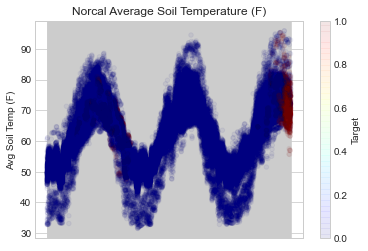

In [24]:
norcal_df.plot.scatter(x='Date', y='Avg Soil Temp (F)', c='Target', alpha=0.05, colormap='jet')
plt.title('Norcal Average Soil Temperature (F)')
plt.savefig('norcal_soil.png')
plt.show()


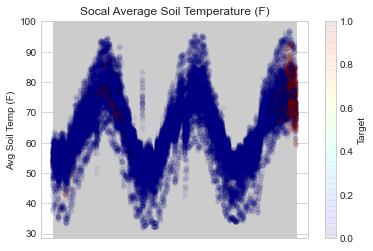

In [25]:
socal_df.plot.scatter(x='Date', y='Avg Soil Temp (F)', c='Target', alpha=0.05, colormap='jet')
plt.title('Socal Average Soil Temperature (F)')
plt.savefig('socal_soil.png')
plt.show()

# norcal_df & socal_df

* App Inputs: indicate norcal or socal and a date
* Need to map input date to date span

In [127]:
norcal_df

,Stn Id,Date,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),Target
0,2,1/1/2018,0.06,0.00,219.0,7.3,63.4,35.3,47.8,82.0,46.0,65.0,36.6,3.3,78.3,51.1,0
1,2,1/2/2018,0.04,0.00,127.0,7.4,59.8,37.7,47.2,80.0,52.0,67.0,36.7,3.1,74.5,51.3,0
2,2,1/3/2018,0.04,0.00,125.0,8.4,61.1,37.3,49.9,79.0,49.0,68.0,39.9,4.5,107.5,51.3,0
3,2,1/4/2018,0.07,0.01,219.0,11.6,69.2,48.7,56.8,94.0,52.0,74.0,48.5,5.8,140.2,53.0,0
4,2,1/5/2018,0.07,0.00,239.0,12.7,73.8,47.5,59.8,94.0,49.0,72.0,50.8,4.2,101.4,54.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78403,262,9/14/2020,0.14,0.00,420.0,15.4,84.3,53.7,66.3,95.0,39.0,70.0,56.2,3.4,81.7,69.4,1
78404,262,9/15/2020,0.15,0.00,430.0,15.1,86.8,49.6,66.0,96.0,31.0,69.0,55.7,2.7,64.2,69.0,1
78405,262,9/16/2020,0.15,0.00,445.0,16.2,89.0,53.6,68.0,97.0,30.0,69.0,57.6,3.3,78.2,69.0,1
78406,262,9/17/2020,0.16,0.00,447.0,16.6,88.1,53.3,70.4,97.0,35.0,65.0,58.3,3.3,78.1,69.5,1


In [128]:
socal_df

,Stn Id,Date,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),Target
0,2,1/1/2018,0.06,0.00,219.0,7.3,63.4,35.3,47.8,82.0,46.0,65.0,36.6,3.3,78.3,51.1,0
1,2,1/2/2018,0.04,0.00,127.0,7.4,59.8,37.7,47.2,80.0,52.0,67.0,36.7,3.1,74.5,51.3,0
2,2,1/3/2018,0.04,0.00,125.0,8.4,61.1,37.3,49.9,79.0,49.0,68.0,39.9,4.5,107.5,51.3,0
3,2,1/4/2018,0.07,0.01,219.0,11.6,69.2,48.7,56.8,94.0,52.0,74.0,48.5,5.8,140.2,53.0,0
4,2,1/5/2018,0.07,0.00,239.0,12.7,73.8,47.5,59.8,94.0,49.0,72.0,50.8,4.2,101.4,54.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78403,262,9/14/2020,0.14,0.00,420.0,15.4,84.3,53.7,66.3,95.0,39.0,70.0,56.2,3.4,81.7,69.4,1
78404,262,9/15/2020,0.15,0.00,430.0,15.1,86.8,49.6,66.0,96.0,31.0,69.0,55.7,2.7,64.2,69.0,1
78405,262,9/16/2020,0.15,0.00,445.0,16.2,89.0,53.6,68.0,97.0,30.0,69.0,57.6,3.3,78.2,69.0,1
78406,262,9/17/2020,0.16,0.00,447.0,16.6,88.1,53.3,70.4,97.0,35.0,65.0,58.3,3.3,78.1,69.5,1


In [129]:
norcal_df = norcal_df.set_index(norcal_df['Date'])
norcal_df.drop('Date', axis=1, inplace=True)
socal_df = socal_df.set_index(socal_df['Date'])
socal_df.drop('Date', axis=1, inplace=True)

In [130]:
norcal_df = norcal_df[['Avg Soil Temp (F)', 'Target']]
socal_df = socal_df[['Avg Soil Temp (F)', 'Target']]

In [146]:
norcal_df['Date'] = pd.to_datetime(norcal_df.index)
socal_df['Date'] = pd.to_datetime(socal_df.index)

In [151]:
mask1 = (norcal_df['Date'] >= '2020-09-01') & (norcal_df['Date'] <= '2020-09-18')
mask2 = (socal_df['Date'] >= '2020-09-01') & (socal_df['Date'] <= '2020-09-18')

In [152]:
norcal20 = norcal_df.loc[mask1]
socal20 = socal_df.loc[mask2]

In [153]:
norcal20

,Avg Soil Temp (F),Target,Date
Date,,,
9/1/2020,76.1,0,2020-09-01
9/2/2020,75.9,0,2020-09-02
9/3/2020,75.7,0,2020-09-03
9/4/2020,75.2,1,2020-09-04
9/5/2020,75.1,1,2020-09-05
...,...,...,...
9/14/2020,69.4,1,2020-09-14
9/15/2020,69.0,1,2020-09-15
9/16/2020,69.0,1,2020-09-16


In [154]:
norcal20.drop('Date', axis=1, inplace=True)
socal20.drop('Date', axis=1, inplace=True)

In [157]:
norcal20
socal20

,Avg Soil Temp (F),Target
Date,,
9/1/2020,76.1,0
9/2/2020,75.9,0
9/3/2020,75.7,0
9/4/2020,75.2,1
9/5/2020,75.1,1
...,...,...
9/14/2020,69.4,1
9/15/2020,69.0,1
9/16/2020,69.0,1


In [158]:
norcal_target = norcal20.pop('Target')
socal_target = socal20.pop('Target')

# start with norcal

* different things are different observations
* parse into individual slices of the dataset
* one station id - Sol Rad - expand rest of variables - expand to stations => model


In [161]:
norcal20['Date']=norcal20.index

In [162]:
norcal20['Target']=norcal_target

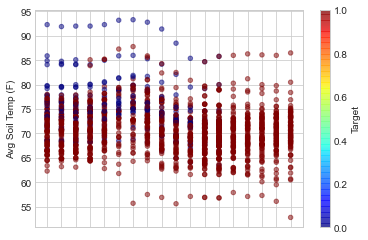

In [163]:
norcal20.plot.scatter(x='Date', y='Avg Soil Temp (F)', c='Target',  alpha=0.5, colormap='jet')
plt.show()

In [164]:
norcal20.drop(['Date', 'Target'], axis=1, inplace=True)

In [169]:
norcal20

,Avg Soil Temp (F)
Date,
9/1/2020,76.1
9/2/2020,75.9
9/3/2020,75.7
9/4/2020,75.2
9/5/2020,75.1
...,...
9/14/2020,69.4
9/15/2020,69.0
9/16/2020,69.0


First we'll write a function to consider every possible group of 50 values followed by one value (for the output) along our time-series data.

In [165]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

In [166]:
def extract_windows(array, clearing_time_index, max_time, sub_window_size):
    examples = []
    start = clearing_time_index + 1 - sub_window_size + 1
    
    for i in range(max_time+1):
        example = array[start+i:start+sub_window_size+i]
        examples.append((example))
        
    return np.vstack(examples)

In [170]:
print(norcal20['Avg Soil Temp (F)'][0:][:,None][0])
print(norcal20['Avg Soil Temp (F)'][0:][:,None][-1])
norcal20.shape

[76.1]
[70.5]


(1740, 1)

In [183]:
no_fire_windows = extract_windows(norcal20['Avg Soil Temp (F)'][0:][:,None], 6,942, 8)
no_fire_windows.shape

(7544, 1)

In [184]:
print(stn2_df_1['Avg Soil Temp (F)'][0:][:,None][0])
print(stn2_df_1['Avg Soil Temp (F)'][0:][:,None][-1])
stn2_df_1.shape

[77.5]
[72.2]


(34, 2)

In [185]:
fire_windows = extract_windows(stn2_df_1['Avg Soil Temp (F)'][0:][:,None], 6, 26, 8)
fire_windows.shape

(216, 1)


Then we'll write a function split the data into training and testing sets. Because it's time-series data we have to do that sequentially rather than shuffling it. They should be completely separate and not overlap, so the the training data isn't used for testing.

In [72]:
def split_and_windowize(data, n_prev, fraction_test=0.3):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

In [158]:
n_prev = 5

In [186]:
X_train1, X_test1, _, _ = split_and_windowize(no_fire_windows, n_prev)
X_train2, X_test2, _, _ = split_and_windowize(fire_windows, n_prev)

In [206]:
print(X_train1.shape, X_test1.shape)
#X_train1 = X_train1.reshape(5269,5,1)
X_test1 = X_test1.reshape(2265,5,1)

(5269, 5, 1) (2265, 5, 1, 1)


In [209]:
print(X_train1.shape, X_test1.shape)

(5269, 5, 1) (2265, 5, 1)


In [207]:
print(X_train2.shape, X_test2.shape)
X_train2 = X_train2.reshape(140,5,1)
X_test2 = X_test2.reshape(66,5,1)

(140, 5, 1, 1) (66, 5, 1, 1)


In [208]:
print(X_train2.shape, X_test2.shape)

(140, 5, 1) (66, 5, 1)


In [210]:
X_train = np.concatenate([X_train1, X_train2])
X_test = np.concatenate([X_test1, X_test2])
y_train = np.concatenate([np.zeros(X_train1.shape[0]), np.ones(X_train2.shape[0])])
y_test = np.concatenate([np.zeros(X_test1.shape[0]), np.ones(X_test2.shape[0])])

In [224]:
X_train.shape, X_test.shape

((5409, 5, 1), (2331, 5, 1))

In [212]:
y_train.shape, y_test.shape

((5409,), (2331,))

In [213]:
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(32, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.LSTM(32, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.LSTM(32, return_sequences=False))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [214]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 5, 32)             1088      
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 32)             8320      
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 17,761
Trainable params: 17,761
Non-trainable params: 0
_________________________________________________________________
None


In [239]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
68/68 [==============================] - 0s 5ms/step - loss: 3.3303e-09 - val_loss: 2.5305
Epoch 2/100
68/68 [==============================] - 0s 5ms/step - loss: 3.1074e-09 - val_loss: 2.5391
Epoch 3/100
68/68 [==============================] - 0s 5ms/step - loss: 2.9121e-09 - val_loss: 2.5472
Epoch 4/100
68/68 [==============================] - 0s 5ms/step - loss: 2.7396e-09 - val_loss: 2.5549
Epoch 5/100
68/68 [==============================] - 0s 5ms/step - loss: 2.5861e-09 - val_loss: 2.5622
Epoch 6/100
68/68 [==============================] - 0s 5ms/step - loss: 2.4488e-09 - val_loss: 2.5690
Epoch 7/100
68/68 [==============================] - 0s 5ms/step - loss: 2.3251e-09 - val_loss: 2.5756
Epoch 8/100
68/68 [==============================] - 0s 5ms/step - loss: 2.2133e-09 - val_loss: 2.5818
Epoch 9/100
68/68 [==============================] - 0s 5ms/step - loss: 2.1116e-09 - val_loss: 2.5877
Epoch 10/100
68/68 [==============================] - 0s 5ms/step - loss:

Epoch 80/100
68/68 [==============================] - 0s 5ms/step - loss: 4.9094e-10 - val_loss: 2.7742
Epoch 81/100
68/68 [==============================] - 0s 5ms/step - loss: 4.8567e-10 - val_loss: 2.7756
Epoch 82/100
68/68 [==============================] - 0s 5ms/step - loss: 4.8051e-10 - val_loss: 2.7770
Epoch 83/100
68/68 [==============================] - 0s 5ms/step - loss: 4.7546e-10 - val_loss: 2.7783
Epoch 84/100
68/68 [==============================] - 0s 6ms/step - loss: 4.7051e-10 - val_loss: 2.7797
Epoch 85/100
68/68 [==============================] - 0s 6ms/step - loss: 4.6566e-10 - val_loss: 2.7810
Epoch 86/100
68/68 [==============================] - 0s 5ms/step - loss: 4.6092e-10 - val_loss: 2.7823
Epoch 87/100
68/68 [==============================] - 0s 5ms/step - loss: 4.5626e-10 - val_loss: 2.7836
Epoch 88/100
68/68 [==============================] - 0s 6ms/step - loss: 4.5171e-10 - val_loss: 2.7849
Epoch 89/100
68/68 [==============================] - 0s 6ms/ste

In [240]:
scores = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy: {round(scores*100,2)}")

Accuracy: 61.26


In [241]:
y_pred = model.predict(X_test)[:,0]
y_pred

array([4.0147657e-10, 4.0148884e-10, 4.0150877e-10, ..., 4.0136328e-10,
       4.0136328e-10, 4.0136788e-10], dtype=float32)

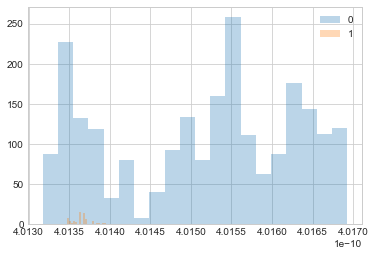

In [242]:
fix, ax = plt.subplots()
ax.hist(y_pred[y_test == 0], alpha=0.3, bins=20, label="0")
ax.hist(y_pred[y_test == 1], alpha=0.3, bins=20, label="1")
ax.legend()

In [248]:
y_test, y_pred

(array([0., 0., 0., ..., 1., 1., 1.]),
 array([4.0147657e-10, 4.0148884e-10, 4.0150877e-10, ..., 4.0136328e-10,
        4.0136328e-10, 4.0136788e-10], dtype=float32))

# Multivariate Time Series

In [14]:
conditions_path = '../data/conditions_df.csv'
df = pd.read_csv(conditions_path)
norcal = ['San Joaquin Valley', 'Sacramento Valley', 'Sierra Foothill', 'Northeast Plateau', 'San Francisco Bay', 'North Coast Valleys', 'Monterey Bay', 'Eastern Sierra Basin & Range']
socal = ['Bishop', 'Imperial/Coachella Valley', 'Los Angeles Basin', 'Central Coast Valleys', 'South Coast Valleys', 'San Bernardino']
todrop = ['Stn Name', 'CIMIS Region']
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
norcal_df = df[df['CIMIS Region'].isin(norcal)]
socal_df = df[df['CIMIS Region'].isin(socal)]
norcal_df.drop(todrop, axis=1, inplace=True)
socal_df.drop(todrop, axis=1, inplace=True)

In [15]:
norcal = ['San Joaquin Valley', 'Sacramento Valley', 'Sierra Foothill', 'Northeast Plateau', 'San Francisco Bay', 'North Coast Valleys', 'Monterey Bay', 'Eastern Sierra Basin & Range']
socal = ['Bishop', 'Imperial/Coachella Valley', 'Los Angeles Basin', 'Central Coast Valleys', 'South Coast Valleys', 'San Bernardino']
todrop = ['Stn Name', 'CIMIS Region']
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
norcal_df = df[df['CIMIS Region'].isin(norcal)]
socal_df = df[df['CIMIS Region'].isin(socal)]
norcal_df.drop(todrop, axis=1, inplace=True)
socal_df.drop(todrop, axis=1, inplace=True)

In [2]:
norcal_df.iloc[1/1/2019:9/13/2020]

NameError: name 'norcal_df' is not defined

In [294]:
#norcal_df_0 = norcal_df[norcal_df['Target']==0]
#norcal_df_1 = norcal_df[norcal_df['Target']==1]

In [17]:
norcal_target = norcal_df.pop('Target')
#norcal_df_0.pop('Target')
#norcal_df_1.pop('Target')

In [18]:
norcal_target

Date
1/1/2018     0
1/2/2018     0
1/3/2018     0
1/4/2018     0
1/5/2018     0
            ..
9/9/2020     1
9/10/2020    1
9/11/2020    1
9/12/2020    1
9/13/2020    1
Name: Target, Length: 77771, dtype: int64

In [19]:
norcal_ids = norcal_df.pop('Stn Id')
#stn_ids_0 = norcal_df_0.pop('Stn Id')
#stn_ids_1 = norcal_df_1.pop('Stn Id')

In [296]:
#norcal_df_0.shape, norcal_df_1.shape

((74746, 12), (3025, 12))

In [20]:
columns = norcal_df.columns
index = norcal_df.index

In [21]:
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
norcal_df = sc.fit_transform(norcal_df)
#norcal_df_0 = sc.fit_transform(norcal_df_0)
#norcal_df_1 = sc.fit_transform(norcal_df_1)

In [22]:
norcal_df = pd.DataFrame(norcal_df)

In [28]:
norcal_df = norcal_df.set_index(index)
norcal_df.columns = columns

In [29]:
norcal_df['Target'] = norcal_target

In [30]:
norcal_df

,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Avg Air Temp (F),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),Target
Date,,,,,,,,,,,
1/1/2018,0.130435,0.000000,0.149386,0.265455,0.429100,0.65,0.753909,0.095436,0.093858,0.304348,0
1/2/2018,0.086957,0.000000,0.086630,0.269091,0.421702,0.67,0.754589,0.087137,0.087302,0.307453,0
1/3/2018,0.086957,0.000000,0.085266,0.305455,0.454994,0.68,0.776343,0.145228,0.144237,0.307453,0
1/4/2018,0.152174,0.001508,0.149386,0.421818,0.540074,0.74,0.834806,0.199170,0.200656,0.333851,0
1/5/2018,0.152174,0.000000,0.163029,0.461818,0.577065,0.72,0.850442,0.132780,0.133713,0.355590,0
...,...,...,...,...,...,...,...,...,...,...,...
9/9/2020,0.239130,0.000000,0.208731,0.509091,0.639951,0.67,0.869477,0.066390,0.067633,0.607143,1
9/10/2020,0.152174,0.000000,0.167121,0.560000,0.622688,0.77,0.887152,0.053942,0.053313,0.593168,1
9/11/2020,0.282609,0.000000,0.281037,0.574545,0.646116,0.74,0.891910,0.045643,0.044686,0.588509,1


In [31]:
norcal_df.shape, norcal_df.columns[10]

((77771, 11), 'Target')

In [32]:
norcal_df = np.array(norcal_df)

In [33]:
lookback= 50
test_size=int(.3 * len(norcal_df))

In [34]:
len(norcal_df) - test_size, test_size

(54440, 23331)

In [ ]:
# Separate into fire and no fire:
no_fire_windows = extract_windows(norcal_df[0:][:,None], 6,942, 8)
no_fire_windows.shape
fire_windows = extract_windows(norcal_df[0:][:,None], 6,942, 8)
fire_windows.shape

In [39]:
conditions_path2 = '../data/notime_df.csv'
df2 = pd.read_csv(conditions_path2)

In [42]:
df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]
df2

,Stn Id,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),Target
0,2,0.06,0.00,219.0,7.3,63.4,35.3,47.8,82.0,46.0,65.0,36.6,3.3,78.3,51.1,0
1,2,0.04,0.00,127.0,7.4,59.8,37.7,47.2,80.0,52.0,67.0,36.7,3.1,74.5,51.3,0
2,2,0.04,0.00,125.0,8.4,61.1,37.3,49.9,79.0,49.0,68.0,39.9,4.5,107.5,51.3,0
3,2,0.07,0.01,219.0,11.6,69.2,48.7,56.8,94.0,52.0,74.0,48.5,5.8,140.2,53.0,0
4,2,0.07,0.00,239.0,12.7,73.8,47.5,59.8,94.0,49.0,72.0,50.8,4.2,101.4,54.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127132,262,0.11,0.00,306.0,14.0,82.5,53.2,64.9,95.0,33.0,67.0,53.6,2.6,63.1,70.6,1
127133,262,0.07,0.00,245.0,15.4,77.1,52.4,63.5,96.0,52.0,77.0,56.2,2.3,54.8,69.7,1
127134,262,0.13,0.00,412.0,15.8,85.1,50.6,65.4,97.0,39.0,74.0,56.9,2.1,49.8,69.4,1
127135,262,0.10,0.00,338.0,16.7,83.2,50.6,65.0,97.0,46.0,79.0,58.4,1.6,38.8,69.2,1


In [15]:
image_path = '../data/cleaned_data'
filenames = glob.glob(path + '/*/*')
filenames

['../data/cleaned_data/fog_images/2018-04-20_1.jpg',
 '../data/cleaned_data/fog_images/2018-12-26_1.jpg',
 '../data/cleaned_data/fog_images/2018-05-20_1.jpg',
 '../data/cleaned_data/fog_images/2020-07-01.jpg',
 '../data/cleaned_data/fog_images/2020-07-29.jpg',
 '../data/cleaned_data/fog_images/2018-06-12_1.jpg',
 '../data/cleaned_data/fog_images/2018-10-14_1.jpg',
 '../data/cleaned_data/fog_images/2018-07-12_1.jpg',
 '../data/cleaned_data/fog_images/2018-03-01_1.jpg',
 '../data/cleaned_data/fog_images/2019-01-18_1.jpg',
 '../data/cleaned_data/fog_images/2018-02-01_1.jpg',
 '../data/cleaned_data/fog_images/2019-03-04.jpg',
 '../data/cleaned_data/fog_images/2019-03-10.jpg',
 '../data/cleaned_data/fog_images/2018-02-27.jpg',
 '../data/cleaned_data/fog_images/2019-04-19.jpg',
 '../data/cleaned_data/fog_images/2018-05-06.jpg',
 '../data/cleaned_data/fog_images/2019-08-31_1.jpg',
 '../data/cleaned_data/fog_images/2018-05-12.jpg',
 '../data/cleaned_data/fog_images/2019-04-25.jpg',
 '../data/c

In [23]:
filenames_cleaned = [file.strip('../data/cleaned_data/fog_images/') for file in filenames]
filenames_cleaned = [file.strip( '../data/cleaned_data/smoke_images/') for file in filenames]
filenames_cleaned

['fog_images/2018-04-20_1.jp',
 'fog_images/2018-12-26_1.jp',
 'fog_images/2018-05-20_1.jp',
 'fog_images/2020-07-01.jp',
 'fog_images/2020-07-29.jp',
 'fog_images/2018-06-12_1.jp',
 'fog_images/2018-10-14_1.jp',
 'fog_images/2018-07-12_1.jp',
 'fog_images/2018-03-01_1.jp',
 'fog_images/2019-01-18_1.jp',
 'fog_images/2018-02-01_1.jp',
 'fog_images/2019-03-04.jp',
 'fog_images/2019-03-10.jp',
 'fog_images/2018-02-27.jp',
 'fog_images/2019-04-19.jp',
 'fog_images/2018-05-06.jp',
 'fog_images/2019-08-31_1.jp',
 'fog_images/2018-05-12.jp',
 'fog_images/2019-04-25.jp',
 'fog_images/2019-03-17_1.jp',
 'fog_images/2020-05-01_1.jp',
 'fog_images/2019-02-17_1.jp',
 'fog_images/2020-04-01_1.jp',
 'fog_images/2019-01-01.jp',
 'fog_images/2019-08-25.jp',
 'fog_images/2019-06-08.jp',
 'fog_images/2019-08-31.jp',
 'fog_images/2018-09-06.jp',
 'fog_images/2019-01-15.jp',
 'fog_images/2018-09-27_1.jp',
 'fog_images/2019-01-25_1.jp',
 'fog_images/2019-08-19.jp',
 'fog_images/2019-06-20.jp',
 'fog_image

In [21]:
image = Image.open(filenames_cleaned[0])
xsize, ysize = image.size
print("Image size: {} x {}".format(xsize, ysize))
plt.imshow(image)

FileNotFoundError: [Errno 2] No such file or directory: 'fog_images/2018-04-20_1.jp'

In [ ]:
image_input = keras.Input(
    shape=(img_height, img_width, 3), 
    name="satellite_image"
    )  # Variable-length sequence of ints
conditions_input = keras.Input(
    shape=(None,), 
    name="conditions")  # Variable-length sequence of ints
date_input = keras.Input(
    shape=(None,), 
    name="date") # Variable-length sequence of ints

xception_model=load_model('transfer_model_just_in_case.h5')(image_input)

xception = layers.model()(image_input)

x = layers.concatenate([title_features, body_features, tags_input])

# Outputs for both models will be probability for fire x 2
# possibly add xception probability to conditions_df
# add layer that concatenates probability to xgboost prediction probability
# add layer for one dense output
# gives a weight to xgboost probability
fire_risk = layers.Dense(1, name="fire")(x)

bigmodel = keras.Model(
    inputs = [image_input, conditions_input, date_input]
    outputs = fire_risk)